In [28]:
import os
import random
import torch
import numpy as np 
import pandas as pd

device = "cpu"

csv_path = "embeddings/text_chunks_and_embeddings_df.csv"  
text_chunks_and_embedding_df = pd.read_csv(csv_path)

text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
print(embeddings.shape)


torch.Size([1680, 768])


In [30]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902280286, -0.00509552006, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592138022, -0.0166167412, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279801395, 0.0339813568, -0.0206426941, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566836, 0.0381274521, -0.00846857857, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.033026401, -0.00849775691, 0.00957154203, -..."


In [31]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Can use dot product or cosine similarity if outputs of model aren't normalized. If using dot product make sure that the outputs are normalized.

In [32]:
query = "What is the importance of protein?"
print(f"Query: {query}")

#always embed query with the same embedding model as your data 
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

#top-k 
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: What is the importance of protein?
Time take to get scores on 1680 embeddings: 0.00065 seconds.


torch.return_types.topk(
values=tensor([0.7100, 0.7098, 0.6785, 0.6761, 0.6597]),
indices=tensor([547, 601, 585,  46, 584]))

In [33]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
Time take to get scores on 168000 embeddings: 0.00918 seconds.


In [34]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [35]:
print(f"Query: '{query}'\n")
print("Results:")

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'What is the importance of protein?'

Results:
Score: 0.7100
Text:
Defining Protein UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION
PROGRAM AND HUMAN NUTRITION PROGRAM Protein makes up approximately 20 percent of
the human body and is present in every single cell. The word protein is a Greek
word, meaning “of utmost importance.”Proteins are called the workhorses of life
as they provide the body with structure and perform a vast array of functions.
You can stand, walk, run, skate, swim, and more because of your protein-rich
muscles. Protein is necessary for proper immune system function, digestion, and
hair and nail growth, and is involved in numerous other body functions. In fact,
it is estimated that more than one hundred thousand different proteins exist
within the human body. In this chapter you will learn about the components of
protein, the important roles that protein serves within the body, how the body
uses protein, the risks and consequences associated w

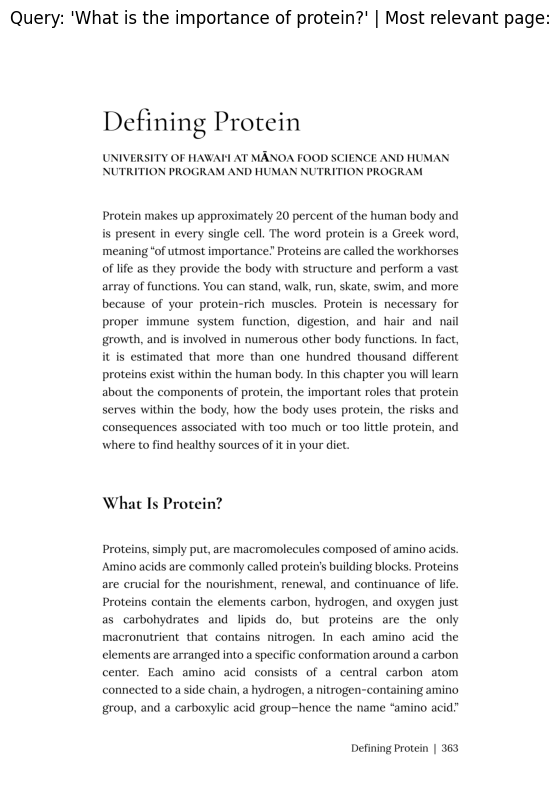

In [38]:
#display page that is being referenced
import fitz

pdf_path = "human-nutrition-text.pdf" 
doc = fitz.open(pdf_path)
page = doc.load_page(41 + 363) #replace with page number above

img = page.get_pixmap(dpi=300)

doc.close()

img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') 
plt.show()

In [9]:
#functions to use in final .py file
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5, #experiment
                                print_time: bool=True):

    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    dot_scores = util.dot_score(query_embedding, embeddings)[0]


    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [10]:
query = "How can I make nori?"

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

(tensor([0.5175, 0.4347, 0.3733, 0.3622, 0.3616]),
 tensor([1705, 1853, 1850, 1851, 1192]))

In [11]:
#Save all these functions to a .py file to run on Ai server
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

Query: How can I make nori?

Results:
Score: 0.5175
Amount per serving Tuna Nori Wraps 5 ingredients · 15 minutes · 4 servings
Directions 1. Divide the tuna, carrot, cucumber and avocado onto each nori
sheet.2. Roll or wrap the tuna-stuffed nori and enjoy immediately. Notes Serving
Size Each serving size will yield approximately 3 small rolls. Storage
Refrigerate all ingredients (except nori sheets) individually up to 3 days.
Assemble and wrap before ready to eat. Ingredients 2 cans Tuna (drained and
flaked) 2 Carrot (smalled, julienned) 1 Cucumber (julienned) 1 Avocado (peeled
and sliced) 12 Nori Sheets (snack size) Nutrition Calories 190 Vitamin C 18mg
Fat 8g Calcium 72mg Saturated 1g Iron 2mg Carbs 13g Vitamin D 39IU Fiber 8g
Vitamin B6 0.5mg Sugar 3g Folate 56µg Protein 21g Vitamin B12 2.1µg Cholesterol
30mg Magnesium 47mg Sodium 239mg Zinc 1mg Potassium 599mg Selenium 59µg Vitamin
A 6495IU Amanda Swan http://amandaswanaprn.com
Page number: 7


Score: 0.4347
82 Cost category Quanti

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

model_id = "google/gemma-2b-it"
print(f"[INFO] Using model_id: {model_id}")

config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_id)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 config=config,
                                                 torch_dtype=torch.float16,  
                                                 low_cpu_mem_usage=False)

llm_model.to("cpu")


[INFO] Using model_id: google/gemma-2b-it


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

In [13]:
input_text = "How can I make nori?"
print(f"Input text:\n{input_text}")

dialogue_template = [
    {"role": "user",
     "content": input_text}
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, 
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
How can I make nori?

Prompt (formatted):
<bos><start_of_turn>user
How can I make nori?<end_of_turn>
<start_of_turn>model



In [14]:
#tokenize query
input_tokens = tokenizer(input_text, return_tensors='pt')
print(f"[INFO] Tokenized input: {input_tokens}")

#generate outputs
with torch.no_grad(): 
    generated_tokens = llm_model.generate(**input_tokens, max_length=250) 


[INFO] Tokenized input: {'input_ids': tensor([[     2,   2299,    798,    590,   1501, 187591, 235336]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [15]:
#decode tokens to text
output_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
print(f"Generated output: {output_text}")

Generated output: How can I make nori?

Nori is a type of seaweed that is often used in sushi and other Japanese dishes. It is a delicate and flavorful seaweed that can be made at home with a few simple ingredients.

**Ingredients:**

* 1 cup of dried nori seaweed, washed and dried
* 1 tablespoon of salt
* 1 tablespoon of sesame oil
* 1 tablespoon of rice vinegar
* 1 teaspoon of sugar
* 1 teaspoon of sesame oil

**Instructions:**

1. **Prepare the seaweed:** Wash and dry the nori seaweed thoroughly.
2. **Season the seaweed:** In a large bowl, combine the salt, sesame oil, rice vinegar, sugar, and sesame oil. Add the seaweed to the bowl and toss to coat.
3. **Let the seaweed rest:** Let the seaweed rest for at least 30 minutes, or up to overnight. This will allow the flavors to develop.
4. **Cook the seaweed:** Heat a large skillet or griddle over medium-high heat. Cook the seaweed for 5-7 minutes per side, or until it is crispy and golden brown.
5. **Serve:** Serve the cooked nori with

In [16]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as in-depth as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What is a healthy breakfast option?
Answer: A healthy breakfast is one that provides a good balance of macronutrients (carbohydrates, proteins, and fats), essential vitamins and minerals, and fiber, which together help sustain energy levels, support metabolism, and promote overall well-being. One example of this is oatmeal topped with berries, a spoonful of almond butter, and a side of Greek yogurt.
\nExample 2:
Query: What are the causes of type 2 diabetes and how can prevent it?
Answer: Type 2 diabetes is primarily caused by a combination of genetic factors and lifestyle choices, such as obesity, lack of physical activity, poor diet, and insulin resistance. It can be prevented by maintaining a healthy weight, eating a balanced diet rich in whole foods, staying physically active, managing stress, and avoiding excessive consumption of sugary and processed foods.
\nExample 3:
Query: What foods should I look at if I want to lose weight and improve heart health?
Answer: Focus on whole foods like vegetables, fruits, whole grains, lean proteins (such as fish, chicken, and legumes), and healthy fats (like avocados, nuts, and olive oil). Also, include foods high in fiber, like oats and leafy greens, and limit processed foods, sugary snacks, and saturated fats to support weight loss and heart health.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    base_prompt = base_prompt.format(context=context, query=query)
    dialogue_template = [{"role": "user", "content": base_prompt}]
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation_prompt=True)
    return prompt

In [17]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")

outputs = llm_model.generate(**input_ids,
                             temperature=0.7,
                             do_sample=True, 
                             max_new_tokens=256)

output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: How can I make nori?
RAG answer:
<bos>**Ingredients:**

* 1 cup seaweed, such as wakame, kombu, or hijiki
* 1 tablespoon salt

**Instructions:**

1. Wash and dry the seaweed thoroughly.
2. Cut the seaweed into thin sheets, about 1/16 to 1/4 inch thick.
3. Rinse the seaweed with cold water and wring out any excess water.
4. Spread the seaweed out on a clean towel or mesh sieve.
5. Season with salt and let it air dry for at least 30 minutes, or up to 24 hours.
6. Once dry, the nori is ready to use.

**Tips:**

* Use high-quality, fresh seaweed for the best results.
* The ideal moisture content for nori is around 15-20%. If the seaweed is too dry, it will be difficult to roll. If it's too wet, it may tear or become mushy.
* Nori can be stored in an airtight container at room temperature for up to 3 days.
* To prevent the nori from becoming limp or discolored, handle it with care.

**Instructions for Making Nori Sushi:**

* Cut the nori into 
CPU times: user 1min 22s, sys: 4.35 s, t

In [18]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    context_items = [pages_and_chunks[i] for i in indices]

    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() 
        
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")

    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [19]:
query = "How can I make nori?"
print(f"Query: {query}")

answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: How can I make nori?
Answer:

The context does not provide any information about how to make nori, so I cannot
answer this query from the provided context.
Context items:


[{'page_number': 7,
  'sentence_chunk': 'Amount per serving Tuna Nori Wraps 5 ingredients · 15 minutes · 4 servings Directions 1. Divide the tuna, carrot, cucumber and avocado onto each nori sheet.2. Roll or wrap the tuna-stuffed nori and enjoy immediately. Notes Serving Size Each serving size will yield approximately 3 small rolls. Storage Refrigerate all ingredients (except nori sheets) individually up to 3 days. Assemble and wrap before ready to eat. Ingredients 2 cans Tuna (drained and flaked) 2 Carrot (smalled, julienned) 1 Cucumber (julienned) 1 Avocado (peeled and sliced) 12 Nori Sheets (snack size) Nutrition Calories 190 Vitamin C 18mg Fat 8g Calcium 72mg Saturated 1g Iron 2mg Carbs 13g Vitamin D 39IU Fiber 8g Vitamin B6 0.5mg Sugar 3g Folate 56µg Protein 21g Vitamin B12 2.1µg Cholesterol 30mg Magnesium 47mg Sodium 239mg Zinc 1mg Potassium 599mg Selenium 59µg Vitamin A 6495IU Amanda Swan http://amandaswanaprn.com',
  'chunk_char_count': 893,
  'chunk_word_count': 142,
  'chunk_